# MORDM optimization
## Imports


In [1]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario, HypervolumeMetric
from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress, to_problem)
import matplotlib.pyplot as plt
import numpy as np

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## Prepare model and settings

In [2]:
model, planning_steps = get_model_for_problem_formulation(2)

#The model requires a reference scenario to "kick-start"
reference_scenario = Scenario('reference', **{
    'discount rate-0': 1.5,
    'discount rate-1': 1.5,
    'discount rate-2': 1.5,
    'A.0_ID flood wave shape': 75,
    'A.1_Bmax': 240,
    'A.1_pfail': 0.25,
    'A.1_Brate': 10,
    'A.2_Bmax': 240,
    'A.2_pfail': 0.25,
    'A.2_Brate': 10,
    'A.3_Bmax': 240,
    'A.3_pfail': 0.25,
    'A.3_Brate': 10,
    'A.4_Bmax': 240,
    'A.4_pfail': 0.25,
    'A.4_Brate': 10,
    'A.5_Bmax': 240,
    'A.5_pfail': 0.25,
    'A.5_Brate': 10
})

convergence_metrics = [EpsilonProgress()]
nfe = 12000
epsilon = [0.5,0.5,0.5,0.01,0.01]

# Each epsilon value corresponds to a model outcome. The model outcomes are:
# expected damages, dike investment costs, rfr costs, evacuation cost, and casualties
# We select higher epsilon values to damages and costs, while we choose lower values for evacuation costs and casualties.


## Optimize and study convergence

In [4]:
# Create the data folder if it doesn't exist
from pathlib import Path
Path("./MORDM_Data").mkdir(parents=True, exist_ok=True)

# Define the convergence metrics
convergence_metrics = [
    # Save data as archive
    ArchiveLogger(
        "./MORDM_Data",
        [l.name for l in model.levers],
        [o.name for o in model.outcomes],
        base_filename="MORDM_HV_1.tar.gz",
    ),
    # Track epsilon progress
    EpsilonProgress(),
]

# Optimize and study convergence
with MultiprocessingEvaluator(model) as evaluator:
    optimization_result, optimization_convergence = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=epsilon,  convergence=convergence_metrics,reference=reference_scenario)

[MainProcess/INFO] pool started with 10 workers
12982it [04:21, 49.60it/s]                                                     
[MainProcess/INFO] optimization completed, found 498 solutions
[MainProcess/INFO] terminating pool


In [ ]:
### Convergence epsilon plot

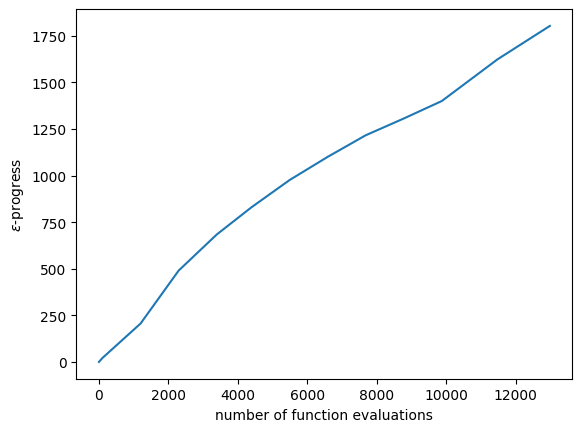

In [5]:
fig, ax = plt.subplots()
ax.plot(optimization_convergence.nfe, optimization_convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

In [6]:
from ema_workbench import save_results
#save_results(total, 'MORDM_100k_ep0.25.tar.gz'.format(nfe))

In [8]:
# Select only those policies that result in an acceptable # of deaths
result_allowable_deaths = optimization_result[optimization_result['Expected Number of Deaths'] < 0.001]
result_allowable_deaths

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
9,0,1,1,0,1,0,1,1,1,0,...,1,4,7,0,0,5.930665e+06,1.560201e+08,600300000.0,122.391210,0.000406
34,0,1,1,0,0,0,1,1,1,0,...,2,5,5,0,0,6.194954e+05,1.591087e+08,382500000.0,0.000000,0.000169
40,0,1,0,0,1,0,1,1,1,0,...,1,4,4,0,0,5.900176e+06,1.404248e+08,636900000.0,121.945073,0.000402
154,0,1,0,0,1,0,1,1,1,1,...,0,2,4,0,0,0.000000e+00,1.546545e+08,758100000.0,0.000000,0.000000
177,0,0,0,0,0,0,0,0,0,0,...,0,2,7,0,0,0.000000e+00,2.340041e+08,0.0,0.000000,0.000000
205,1,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0.000000e+00,2.011710e+08,84600000.0,0.000000,0.000000
325,1,1,1,0,0,0,1,1,1,0,...,0,5,6,0,0,0.000000e+00,1.619496e+08,345900000.0,0.000000,0.000000
373,0,1,1,0,1,0,1,1,1,0,...,1,4,7,0,0,1.810226e+07,1.456503e+08,479100000.0,430.145035,0.000880
419,0,1,1,0,0,0,1,1,0,0,...,0,2,7,0,0,0.000000e+00,1.714727e+08,230600000.0,0.000000,0.000000
485,1,0,1,0,0,0,1,1,1,0,...,0,5,6,0,0,5.961153e+06,1.527881e+08,261300000.0,122.837347,0.000410


In [9]:
# Remove columns for outcomes from the dataframe, resulting in a df of polcies
policies = result_allowable_deaths.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
9,0,1,1,0,1,0,1,1,1,0,...,0,6,0,0,6,1,4,7,0,0
34,0,1,1,0,0,0,1,1,1,0,...,0,6,0,0,4,2,5,5,0,0
40,0,1,0,0,1,0,1,1,1,0,...,0,5,0,0,5,1,4,4,0,0
154,0,1,0,0,1,0,1,1,1,1,...,0,6,0,0,3,0,2,4,0,0
177,0,0,0,0,0,0,0,0,0,0,...,0,7,0,0,6,0,2,7,0,0
205,1,0,0,0,0,0,0,0,0,0,...,0,7,0,0,5,0,0,6,0,0
325,1,1,1,0,0,0,1,1,1,0,...,0,3,0,0,5,0,5,6,0,0
373,0,1,1,0,1,0,1,1,1,0,...,0,5,0,0,2,1,4,7,0,0
419,0,1,1,0,0,0,1,1,0,0,...,0,7,0,0,5,0,2,7,0,0
485,1,0,1,0,0,0,1,1,1,0,...,0,5,0,0,10,0,5,6,0,0


### Parcoords plots

In [17]:
from ema_workbench.analysis import parcoords

data = optimization_result.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.title("All scenarios")
plt.show()


data = result_allowable_deaths.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.title("Only scenarios with tolerably low death risk")
plt.show()

AttributeError: 'tuple' object has no attribute 'loc'

In [11]:
# Load data from archive (necessary?)
archives = ArchiveLogger.load_archives("./MORDM_Data/MORDM_HV_1.tar.gz")

## Hypervolume

Here, there is an issue between the dike model and the EMA Workbench. The dike model defines value keys (levers, uncertainties, outcomes) that do not follow Python identifier standards, by including spaces or dots, or starting with digits.

We avoid this by replacing disallowed symbols with allowed (but otherwise unused) symbols, Ç and Ñ. We also add the letter "A" in front of keys starting with digits.

In [12]:
from copy import deepcopy

result_sanitized = optimization_result.copy()
model_sanitized = deepcopy(model)

# Here, we need to rename...
def sanitize_as_python_identifier(x):
    # Replace dots
    x = x.replace(".","Ç")
    # Replace spaces
    x = x.replace(" ","Ñ")
    # Add letter if starts with digit
    if x.startswith(("0","1","2","3","4","5")):
        x = "A" + x
    return x

# Reverse functions for if we need to get the original labels...
def desanitize_as_python_identifier(x):
    # Replace dots
    x = x.replace("Ç",".")
    # Replace spaces
    x = x.replace("Ñ"," ")
    # Add letter if starts with digit
    if x.startswith(("A0","A1","A2","A3","A4","A5")):
        x = x[1:]
    return x

result_sanitized.columns = [sanitize_as_python_identifier(x) for x in result_sanitized.columns]

for lev in model_sanitized.levers:
    lev.name = sanitize_as_python_identifier(lev.name)

for unc in model_sanitized.uncertainties:
    unc.name = sanitize_as_python_identifier(unc.name)

for out in model_sanitized.outcomes:
    out.name = sanitize_as_python_identifier(out.name)

In [13]:
problem = to_problem(model_sanitized, searchover="levers")

hv = HypervolumeMetric(result_sanitized, problem)

print(f"Going over {len(archives.items())} archives...")
hypervolume = []
for i, (nfe, archive) in enumerate(archives.items()):
    print("Hypervolume calculate for archive #" + str(i))
    archive_sanitized = archive
    archive_sanitized.columns = [sanitize_as_python_identifier(x) for x in archive_sanitized.columns]
    the_result = (nfe, hv.calculate(archive))
    hypervolume.append(the_result)

hypervolume.sort(key=lambda x:x[0])
hypervolume = np.asarray(hypervolume)


Doing hypervolume metric...
Going over archives...
Archive #0
Archive #1
Archive #2
Archive #3
Archive #4
Archive #5
Archive #6
Archive #7
Archive #8
Archive #9
Archive #10
Archive #11
Archive #12


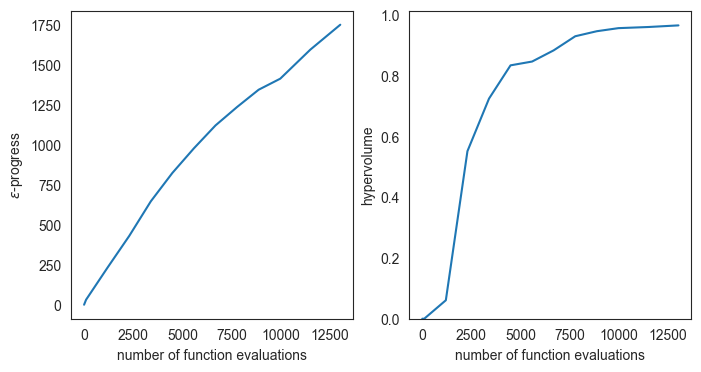

In [14]:
# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(optimization_convergence.nfe, optimization_convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
ax2.set_ylim(ymin=0)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

Filtering the found solutions to those that are most important for the Delta Commission.